In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
#读取训练数据和培训数据
train=pd.read_csv('/kaggle/input/titanic/train.csv',header=0)
test=pd.read_csv('/kaggle/input/titanic/test.csv',header=0)
#观察训练数据中的一些值。例如最大值，最小值，均值等等
train.describe(include="all")
ids=test['PassengerId']
#取5行展示训练数据
train.sample(5)
print(pd.isnull(train).sum())#观察train数据中确实属性数据的汇总

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------- 

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------- 

Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
---------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957
---------- 



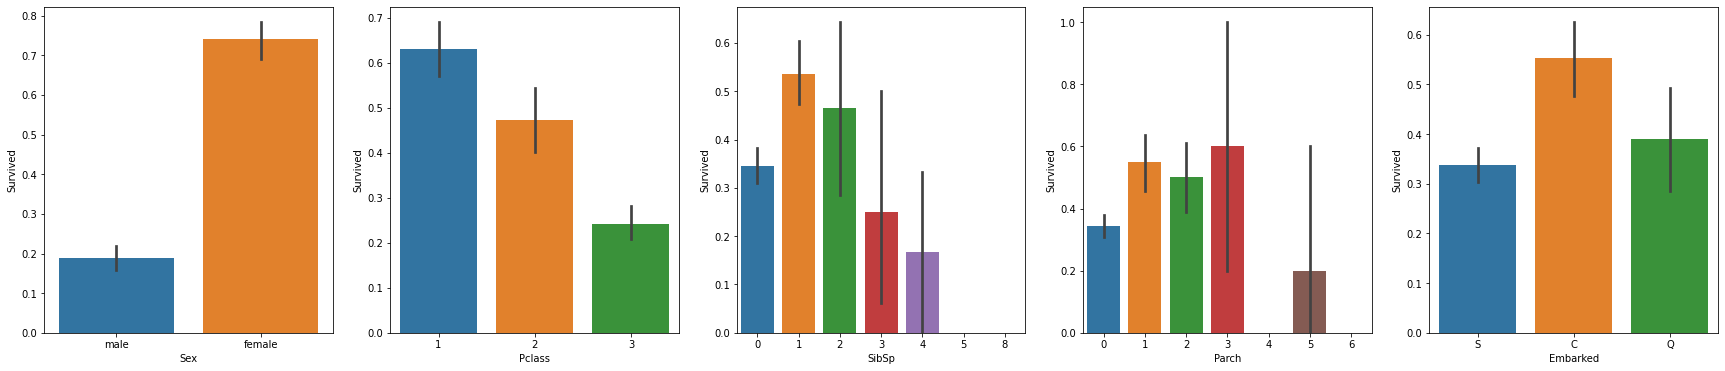

In [3]:
features = ['Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked']
fig, saxis = plt.subplots(1, len(features),figsize=(len(features) * 6,6))
for ind, x in enumerate(features):
    print('Survival Correlation by:', x)
    print(train[[x, "Survived"]].groupby(x, as_index=False).mean()) 
    print('-'*10, '\n')
    #draw a bar plot of survival by sex
    sns.barplot(x, y="Survived", data=train, ax = saxis[ind])

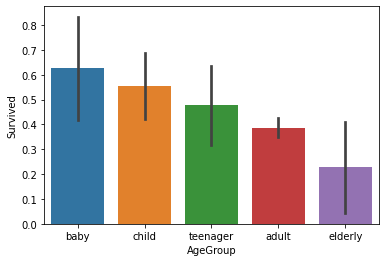

In [4]:
# 对年龄进行查看分类
bins = [0, 2, 12, 17, 60, np.inf]
labels = ['baby', 'child', 'teenager', 'adult', 'elderly']
age_groups = pd.cut(train.Age, bins, labels = labels)
train['AgeGroup'] = age_groups
sns.barplot(x="AgeGroup", y="Survived", data=train)
plt.show()

Survuval Correlation by:Cabin
   CabinBool  Survived
0          0  0.299854
1          1  0.666667


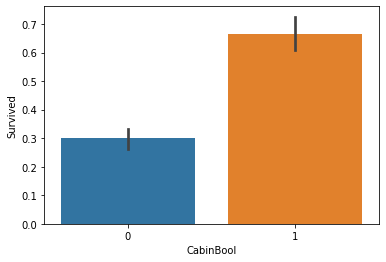

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeGroup,CabinBool
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,adult,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,adult,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,adult,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,adult,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,adult,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,adult,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,adult,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,NaN,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,adult,1


In [5]:
# 关注Cabin
train["CabinBool"]=(train["Cabin"].notnull().astype('int'))
test["CabinBool"]=(test["Cabin"].notnull().astype('int'))
print('Survuval Correlation by:Cabin')
print(train[["CabinBool","Survived"]].groupby("CabinBool",as_index=False).mean())
sns.barplot(x="CabinBool",y="Survived",data=train)
plt.show()

train

In [6]:
#联合test和train数据，
all_data = pd.concat([train, test], ignore_index=True)
print(all_data.shape)
all_data

(1309, 14)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeGroup,CabinBool
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,adult,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,adult,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,adult,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,adult,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,adult,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,NaN,0
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,NaN,1
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,NaN,0
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,NaN,0


In [7]:
# 填充为Nan的数据
all_data['Embarked'].fillna(all_data['Embarked'].mode()[0], inplace = True)
all_data['Fare'].fillna(all_data['Fare'].median(), inplace = True)
all_data['Embarked'].mode()

0    S
dtype: object

In [8]:
all_data['Title'] = all_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

all_data['Title'].value_counts()
#将名字前5个最多的转换成列表形式
frequent_titles = all_data['Title'].value_counts()[:5].index.tolist()
frequent_titles

all_data['Title'] = all_data['Title'].apply(lambda x: x if x in frequent_titles else 'Other')
# all_data.head()

In [9]:
# 将名字按照年龄组均值进行填充
median_ages = {}
# calculate median age for different titles
for title in frequent_titles:
    median_ages[title] = all_data.loc[all_data['Title'] == title]['Age'].median()
median_ages['Other'] =  all_data['Age'].median()
all_data.loc[all_data['Age'].isnull(), 'Age'] = all_data[all_data['Age'].isnull()]['Title'].map(median_ages)

median_ages

{'Mr': 29.0,
 'Miss': 22.0,
 'Mrs': 35.5,
 'Master': 4.0,
 'Rev': 41.5,
 'Other': 28.0}

In [10]:
from sklearn.preprocessing import LabelEncoder

Cat_Features = ['Sex', 'Embarked', 'Title']
for feature in Cat_Features:
    label = LabelEncoder()
    all_data[feature] = label.fit_transform(all_data[feature])

all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeGroup,CabinBool,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,2,adult,0,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,0,adult,1,3
2,3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2,adult,0,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,2,adult,1,3
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,2,adult,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",1,29.0,0,0,A.5. 3236,8.0500,NaN,2,NaN,0,2
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,C105,0,NaN,1,4
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,2,NaN,0,2
1307,1308,NaN,3,"Ware, Mr. Frederick",1,29.0,0,0,359309,8.0500,NaN,2,NaN,0,2


In [11]:
Cont_Features = ['Age', 'Fare']
num_bins = 5
for feature in Cont_Features:
    bin_feature = feature + 'Bin'
    all_data[bin_feature] = pd.qcut(all_data[feature], num_bins)
    label = LabelEncoder()
    all_data[bin_feature] = label.fit_transform(all_data[bin_feature])
    
all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeGroup,CabinBool,Title,AgeBin,FareBin
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,2,adult,0,2,1,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,0,adult,1,3,3,4
2,3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2,adult,0,1,1,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,2,adult,1,3,3,4
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,2,adult,0,2,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",1,29.0,0,0,A.5. 3236,8.0500,NaN,2,NaN,0,2,2,1
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,C105,0,NaN,1,4,3,4
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,2,NaN,0,2,3,0
1307,1308,NaN,3,"Ware, Mr. Frederick",1,29.0,0,0,359309,8.0500,NaN,2,NaN,0,2,2,1


In [12]:
#取名字第一个单词
all_data['Surname'] = all_data.Name.str.extract(r'([A-Za-z]+),', expand=False)
all_data['TicketPrefix'] = all_data.Ticket.str.extract(r'(.*\d)', expand=False)
all_data['Surname_Ticket'] = all_data['Surname'] + all_data['TicketPrefix']
all_data['IsFamily'] = all_data.Surname_Ticket.duplicated(keep=False).astype(int)

all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,AgeGroup,CabinBool,Title,AgeBin,FareBin,Surname,TicketPrefix,Surname_Ticket,IsFamily
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,...,2,adult,0,2,1,0,Braund,A/5 21171,BraundA/5 21171,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,...,0,adult,1,3,3,4,Cumings,PC 17599,CumingsPC 17599,1
2,3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,...,2,adult,0,1,1,1,Heikkinen,STON/O2. 3101282,HeikkinenSTON/O2. 3101282,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,...,2,adult,1,3,3,4,Futrelle,113803,Futrelle113803,1
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,...,2,adult,0,2,3,1,Allen,373450,Allen373450,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",1,29.0,0,0,A.5. 3236,8.0500,...,2,NaN,0,2,2,1,Spector,A.5. 3236,SpectorA.5. 3236,0
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,...,0,NaN,1,4,3,4,Ocana,PC 17758,OcanaPC 17758,0
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,...,2,NaN,0,2,3,0,Saether,SOTON/O.Q. 3101262,SaetherSOTON/O.Q. 3101262,0
1307,1308,NaN,3,"Ware, Mr. Frederick",1,29.0,0,0,359309,8.0500,...,2,NaN,0,2,2,1,Ware,359309,Ware359309,0


In [13]:
all_data['Child'] = all_data.Age.map(lambda x: 1 if x <=16 else 0)
FamilyWithChild = all_data[(all_data.IsFamily==1)&(all_data.Child==1)]['Surname_Ticket'].unique()
len(FamilyWithChild)

66

In [14]:
all_data['FamilyId'] = 0
for ind, identifier in enumerate(FamilyWithChild):
    all_data.loc[all_data.Surname_Ticket==identifier, ['FamilyId']] = ind + 1

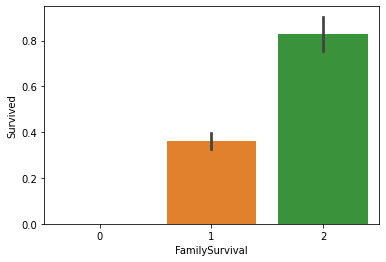

In [15]:
all_data['FamilySurvival'] = 1 
Survived_by_FamilyId = all_data.groupby('FamilyId').Survived.sum()
for i in range(1, len(FamilyWithChild)+1):
    if Survived_by_FamilyId[i] >= 1:
        all_data.loc[all_data.FamilyId==i, ['FamilySurvival']] = 2
    elif Survived_by_FamilyId[i] == 0:
        all_data.loc[all_data.FamilyId==i, ['FamilySurvival']] = 0
sns.barplot(x='FamilySurvival', y='Survived', data=all_data)
plt.show()

In [16]:
train = all_data[: len(train)]
test = all_data[len(train):]
train.shape

# keep only some columns
X_train = train[['Pclass', 'Sex', 'Parch', 'Embarked', 'CabinBool', 'Title', 'AgeBin', 'FareBin', 'FamilySurvival']]
y_train = train['Survived']

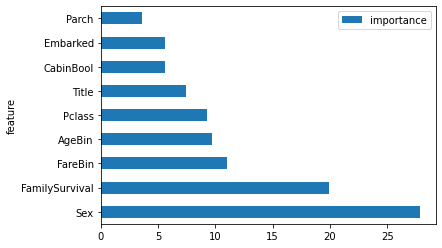

,feature,importance
0,Pclass,9.232980
1,Sex,27.838173
2,Parch,3.599490
3,Embarked,5.636235
4,CabinBool,5.639726
5,Title,7.419112
6,AgeBin,9.707593
7,FareBin,10.992385
8,FamilySurvival,19.934306


In [17]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(verbose=False)
model.fit(X_train, y_train)
importance = pd.DataFrame({'feature':X_train.columns, 'importance': model.feature_importances_})
importance.sort_values('importance', ascending=False).set_index('feature').plot(kind='barh')
plt.show()

importance

In [18]:
# main_features = ['Sex', 'FamilySurvival', 'FareBin', 'Pclass', 'Title']
main_features = ['Sex']

X_test = test[main_features]
X_train = train[main_features]

In [19]:
from sklearn.model_selection import cross_val_score
#计算模型的的得分
cross_val_score(estimator=model, X=X_train, y=y_train, cv=5).mean()

0.7867365513778168

In [20]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn import svm, neighbors
from xgboost import XGBClassifier

ensemble = [CatBoostClassifier(verbose=False), RandomForestClassifier(), svm.NuSVC(probability=True), neighbors.KNeighborsClassifier()]

classifiers_with_names = []
_ = [classifiers_with_names.append((clf.__class__.__name__, clf)) for clf in ensemble]
voting = VotingClassifier(classifiers_with_names, voting='hard')

cv_results = cross_validate(voting, X_train, y_train, cv=5)
print(cv_results['test_score'].mean())

voting.fit(X_train, y_train)
predictions = voting.predict(X_test)

0.7867365513778168


In [21]:
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions.astype(int)})
output.to_csv('submission.csv', index=False)